# Task Learning

1. [Segmentation](#segmentation)

Compare different approaches to building a subgoal model.

2. [Prediction](#prediction)

Seek an online computation of posterior $p(z_i | s_i, a_i, z_{-i})$
    

## Segmentation <a class="anchor" id="first-bullet"></a>

Segmentation uses Bayesian inference to discover latent subgoals in demonstration set. The three methods we will explore are
- BNIRL - Michini
- MBNIRL - Modified BNIRL (a. la. mitch)
- DPMIRL - Maske, still some concerns here

Start by prepping the dataset and importing the `learning` module.

In [1]:
%matplotlib notebook

In [2]:
import learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import trajectories
from jupyter_extras import log_progress
# import seaborn as sns

In [3]:
matplotlib.style.use('mitch-exp')

In [4]:
ls trial_data

manual_mitch_1102_1814.csv


In [5]:
path = 'trial_data/' + 'manual_mitch_1102_1814.csv'

pos, rate_sm = learning.compute_rate(path)
rate_sm = np.nan_to_num(rate_sm)

<IPython.core.display.Javascript object>


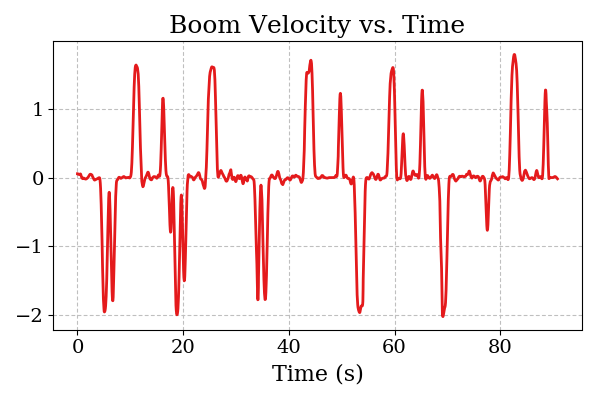

In [6]:
plt.figure()
plt.plot(pos[0][:-1], rate_sm[0])
plt.title('Boom Velocity vs. Time')
plt.xlabel('Time (s)')
plt.tight_layout()

___

In [7]:
labels = np.copy(rate_sm)
# etas = [1, 1, 0.1, 3]
thresholds = [0.2]*3 + [0.05]

for i in range(len(labels)):
#     labels[i] = learning.k_means_action_primitives(rate_sm[i], threshold=True, eta=etas[i])
    labels[i] = learning.get_action_primitives(rate_sm[i], thresholds[i])

<IPython.core.display.Javascript object>


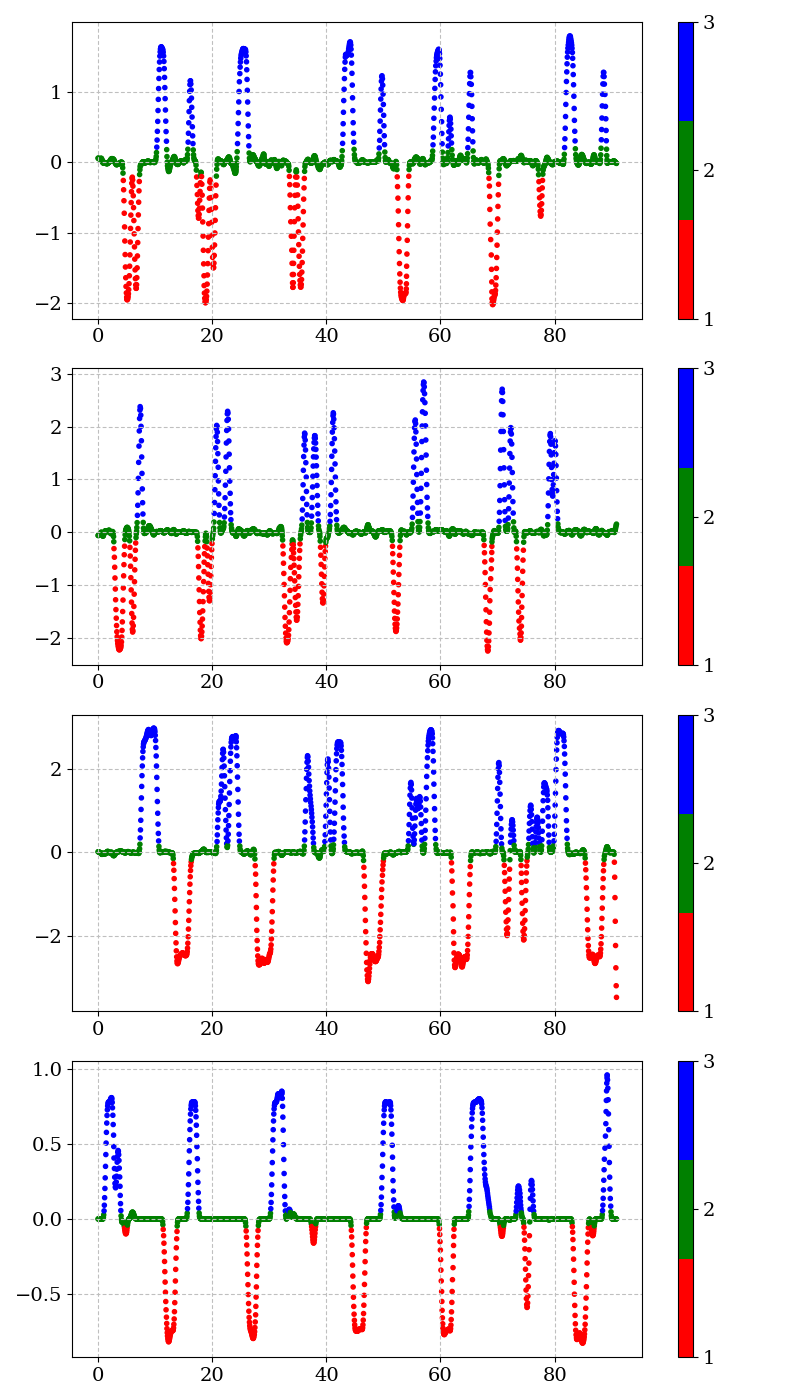

In [8]:
plt.figure(figsize=(8, 14))
# plt.title('Action Primitive Clusters for Each Actuator')

for i in range(4):
    plt.subplot(4, 1, i+1)
    learning.cluster_plot_new(pos[0][:-1], rate_sm[i], labels[i])

plt.tight_layout()

In [9]:
labels_t = labels.transpose()
label_set = set([tuple(label) for label in labels_t])
print('There are %i unique action primitives.') % len(label_set)

There are 34 unique action primitives.


Assign numerical labels for each action primitive.

In [10]:
action_primitives = tuple([list(label_set)[i] for i in range(len(label_set))])
action_primitives

((2.0, 3.0, 2.0, 2.0),
 (2.0, 2.0, 1.0, 1.0),
 (2.0, 3.0, 3.0, 2.0),
 (2.0, 2.0, 1.0, 2.0),
 (2.0, 3.0, 3.0, 1.0),
 (2.0, 1.0, 3.0, 2.0),
 (2.0, 3.0, 2.0, 1.0),
 (2.0, 1.0, 1.0, 3.0),
 (1.0, 1.0, 2.0, 2.0),
 (2.0, 2.0, 3.0, 2.0),
 (2.0, 2.0, 2.0, 2.0),
 (2.0, 1.0, 2.0, 2.0),
 (2.0, 2.0, 2.0, 1.0),
 (1.0, 2.0, 2.0, 1.0),
 (2.0, 2.0, 1.0, 3.0),
 (3.0, 2.0, 1.0, 3.0),
 (2.0, 1.0, 1.0, 2.0),
 (1.0, 1.0, 2.0, 1.0),
 (2.0, 2.0, 3.0, 3.0),
 (3.0, 2.0, 2.0, 1.0),
 (2.0, 1.0, 2.0, 3.0),
 (3.0, 2.0, 2.0, 2.0),
 (1.0, 2.0, 2.0, 2.0),
 (3.0, 2.0, 3.0, 2.0),
 (1.0, 2.0, 3.0, 2.0),
 (2.0, 3.0, 1.0, 2.0),
 (3.0, 2.0, 1.0, 2.0),
 (3.0, 2.0, 1.0, 1.0),
 (1.0, 1.0, 2.0, 3.0),
 (2.0, 2.0, 3.0, 1.0),
 (1.0, 3.0, 2.0, 2.0),
 (3.0, 2.0, 2.0, 3.0),
 (2.0, 2.0, 2.0, 3.0),
 (1.0, 2.0, 2.0, 3.0))

In [11]:
action_primitives.index((2, 2, 2, 2))

10

___

### Action Primitive Visualization

Visualize the action primitives categories during demonstration.

In [12]:
action_class = np.zeros((len(labels_t)))
for i, primitive in enumerate(labels_t):
    action_class[i] = action_primitives.index(tuple(primitive))

<IPython.core.display.Javascript object>


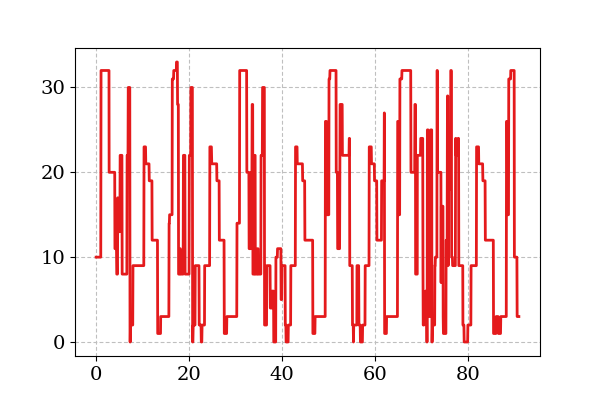

In [13]:
plt.figure()
plt.plot(pos[0][:-1], action_class)

___

## Consolidate

Consolidate action primitive segments.

In [14]:
labels_t

array([[ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       ..., 
       [ 2.,  2.,  1.,  2.],
       [ 2.,  2.,  1.,  2.],
       [ 2.,  2.,  1.,  2.]])

In [15]:
from itertools import groupby

In [16]:
indexes = []
action_temp = []

for key, group in groupby(zip(range(len(labels_t)), labels_t.tolist()), lambda x: x[1]):
    temp = next(group)
    indexes.append(temp[0])
    action_temp.append(temp[1])

action_condense = np.array(action_temp)

len(indexes)

161

In [17]:
states = np.array(pos[1:]).transpose()
states_condense = np.array([states[i] for i in indexes])
states_condense.shape

(161, 4)

___

# 1.a. BNIRL 

Bayesian nonparametric reinforcement learning, Michini *et. al.*

In [18]:
# Prep the state position array
assert states_condense.shape == action_condense.shape

In [19]:
# Initialize the subgoal partition labels all to zero, and size to track convergence
partitions = [0]*(len(states_condense))
iters = 5
partition_dist = np.zeros((iters, len(states_condense)))
size = np.zeros((iters))

# Run BNIRL for _ iterations # eta works around 0.0000001
for i in log_progress(range(iters)):
    partitions = learning.bnirl_sampling_3(states_condense, partitions, action_condense, verbose=False, eta=10000)
    partition_dist[i] = np.array(partitions)
    size[i] = (len(set(partitions)))
    

<IPython.core.display.Javascript object>


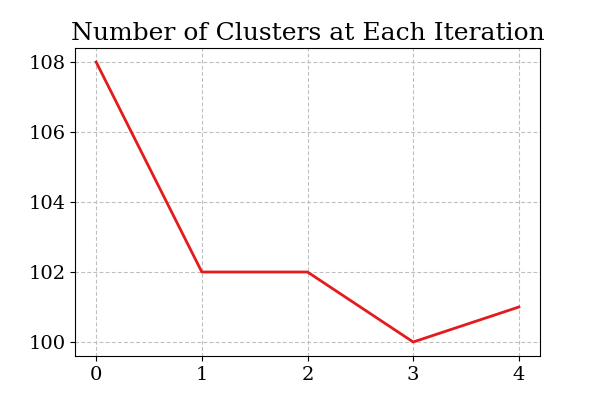

In [20]:
# Not too useful...
plt.figure()
plt.plot(size)
plt.title('Number of Clusters at Each Iteration')

In [21]:
from scipy import stats

In [22]:
partition_dist.shape

(5, 161)

In [23]:
modes = np.zeros(partition_dist.shape)
# modes = np.zeros(len(states_condense))
brn = 0

# Store mode for each state over Gibbs sample sweeps up to ith iteration
for j in range(len(partition_dist)): # 0-200
    for i in range(partition_dist.shape[1]): # 0-161
        modes[j, i] = stats.mode(partition_dist[:j+1, i])[0][0]

# for i, gibbs_samples in enumerate(partition_dist[brn:].T):
#     modes[i], _ = stats.mode(gibbs_samples)

mode_set = set([int(mode) for mode in modes[-1]])
counts = [(mode, np.count_nonzero(modes[-1]==mode)) for mode in mode_set]
sorted(counts, key=lambda x: x[1])[::-1]

[(12, 8),
 (1, 8),
 (0, 8),
 (5, 7),
 (8, 7),
 (46, 4),
 (38, 4),
 (33, 4),
 (28, 4),
 (26, 4),
 (23, 4),
 (20, 4),
 (17, 4),
 (14, 4),
 (10, 4),
 (9, 4),
 (3, 4),
 (2, 4),
 (42, 3),
 (30, 3),
 (15, 3),
 (7, 3),
 (6, 3),
 (79, 2),
 (59, 2),
 (58, 2),
 (51, 2),
 (48, 2),
 (45, 2),
 (41, 2),
 (36, 2),
 (35, 2),
 (25, 2),
 (24, 2),
 (18, 2),
 (13, 2),
 (11, 2),
 (4, 2),
 (129, 1),
 (97, 1),
 (93, 1),
 (92, 1),
 (91, 1),
 (90, 1),
 (77, 1),
 (74, 1),
 (31, 1),
 (72, 1),
 (68, 1),
 (64, 1),
 (63, 1),
 (61, 1),
 (56, 1),
 (54, 1),
 (53, 1),
 (47, 1),
 (44, 1),
 (43, 1),
 (40, 1),
 (39, 1),
 (37, 1),
 (34, 1),
 (21, 1),
 (133, 1)]

In [24]:
len(set(modes[10]))

IndexError: index 10 is out of bounds for axis 0 with size 5

<IPython.core.display.Javascript object>


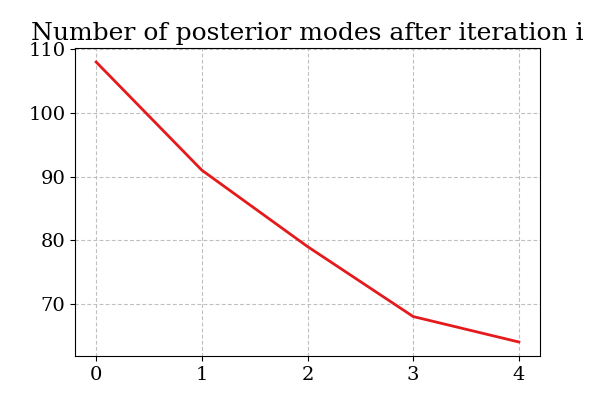

In [25]:
plt.figure()
plt.plot([len(set(mode)) for mode in modes])

plt.title('Number of posterior modes after iteration i')

# Visualize BNIRL Subgoals

Compute forward kinematics and visualize subgoals.

In [26]:
from mpl_toolkits.mplot3d import Axes3D

In [27]:
states_condense.T[0].shape

(161,)

In [28]:
def orient_plot(ax):
    ax.set_xlim3d([-20, 80])
    ax.set_ylim3d([0, 80])
    ax.set_zlim3d([0, 50])
    ax.view_init(azim=-142, elev=14)

In [29]:
# Vectorize the forward kinematics
forward_kin_vec = np.vectorize(trajectories.forward_kin_v)

states_xyz = np.array(forward_kin_vec(trajectories.exc, states_condense.T[3],
                            states_condense.T[0], states_condense.T[1],
                            states_condense.T[2]))

# Correct for wacky base frame in forward kinematics
# Adding 17.1 to Z dimension, moves the frame down to ground level
states_xyz_bias = np.array(states_xyz)
states_xyz_bias[2] = states_xyz_bias[2] + 17.1

states_xyz_bias.shape

(3, 161)

## Visualize all states in observation set

<IPython.core.display.Javascript object>


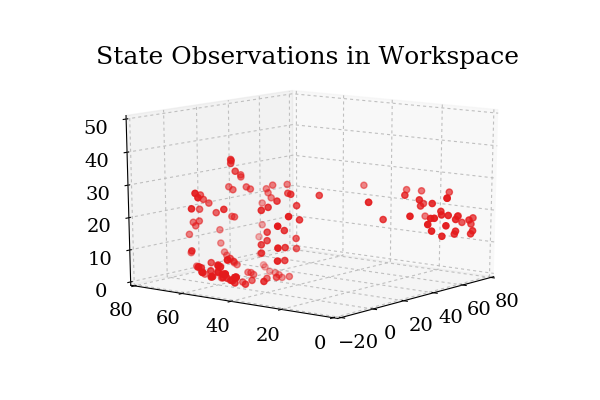

In [30]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('State Observations in Workspace')

ax.scatter(*np.split(states_xyz_bias, 3), zdir='z')
orient_plot(ax)

___

In [31]:
states_condense.shape, action_condense.shape

((161, 4), (161, 4))

In [32]:
states_project = states_condense + (action_condense - 2)*np.array([0.1, 0.1, 0.1, 0.002])

states_project_xyz_bias = np.array(forward_kin_vec(trajectories.exc, states_project.T[3],
                                    states_project.T[0], states_project.T[1],
                                    states_project.T[2]))

states_project_xyz_bias[2] = states_project_xyz_bias[2] + 17.1
states_project_xyz_bias.shape

(3, 161)

<IPython.core.display.Javascript object>


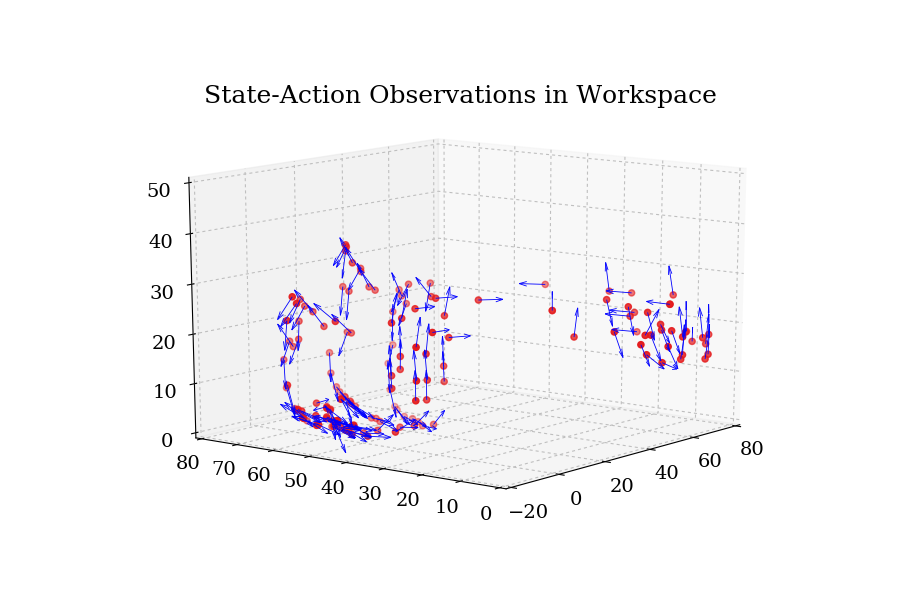

In [33]:
fig = plt.figure()
ax = fig.gca(projection='3d')
args = np.split(states_xyz_bias, 3) + np.split(states_project_xyz_bias - states_xyz_bias, 3)
plt.title('State-Action Observations in Workspace')

ax.scatter(*np.split(states_xyz_bias, 3), zdir='z')
ax.quiver(*args, length=6, normalize=True, color='b', linewidth=0.6)

orient_plot(ax)

___

## Visualize Subgoals

In [34]:
# Extract subgoals in XYZ from states in XYZ
# NOTE SUBGOALS ARE ALSO BIASED TO GND FRAME
listed_modes = list(mode_set)
subgoals_xyz = states_xyz_bias.T[listed_modes]
subgoals_xyz

array([[  5.09146651e+01,   0.00000000e+00,   2.66847627e+01],
       [  5.08780612e+01,   0.00000000e+00,   2.66597923e+01],
       [  2.23171053e+01,   4.56683087e+01,   2.66290450e+01],
       [  8.82270171e+00,   5.82943876e+01,   3.35027567e+01],
       [  9.19659436e+00,   6.03642203e+01,   3.68889541e+01],
       [  4.04458395e+00,   5.87613109e+01,   6.42387220e+00],
       [  9.60510472e+00,   6.06442445e+01,   3.56076819e+01],
       [  1.31402837e+01,   6.22205509e+01,   2.70468232e+01],
       [  1.32813084e+01,   6.28883171e+01,   1.86684772e+01],
       [  1.24485103e+01,   6.74123556e+01,   1.40991243e+01],
       [  1.23833679e+01,   6.70595905e+01,   9.94325491e+00],
       [  1.20646968e+01,   6.53338925e+01,   7.33893972e+00],
       [  1.18714350e+01,   6.42873228e+01,   6.42688898e+00],
       [  1.09670104e+01,   5.93895970e+01,   4.12603040e+00],
       [  8.34313158e+00,   4.51805189e+01,   1.34713233e+01],
       [  8.33249151e+00,   4.51228998e+01,   1.6082623

<IPython.core.display.Javascript object>


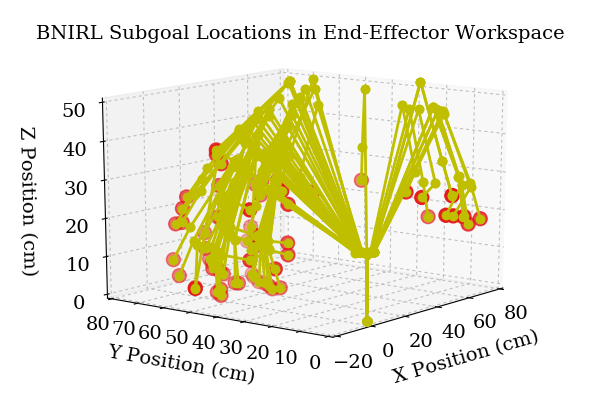

In [35]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('BNIRL Subgoal Locations in End-Effector Workspace', family='serif', fontsize=14)
plt.xlabel('X Position (cm)', family='serif', labelpad=10, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=10, fontsize=14)
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)
# plt.zlabel('z Position (cm)')

for j in mode_set:
    trajectories.draw_exc(ax, states_condense[j], lw=2)
    
ax.scatter(*np.split(subgoals_xyz.T, 3), s=100)

orient_plot(ax)
plt.tight_layout()
# plt.savefig('subgoal_BNIRL.png',dpi=600)

# Animate demonstration with subgoals

Test the draw_exc() func by animating all states. See exc-render.ipynb for examples of draw_exc(). 

In [164]:
from jupyter_extras import log_progress
from matplotlib.animation import FuncAnimation

In [165]:
states.shape

(1712, 4)

In [166]:
# Mode dict for colors
mode_color = dict()

for i, mode in enumerate(listed_modes):
    mode_color[mode] = i

In [167]:
reload(trajectories)

<module 'trajectories' from 'trajectories.py'>

In [168]:
colors = ['b', 'g', 'r', 'y', 'm', 'c']

<IPython.core.display.Javascript object>


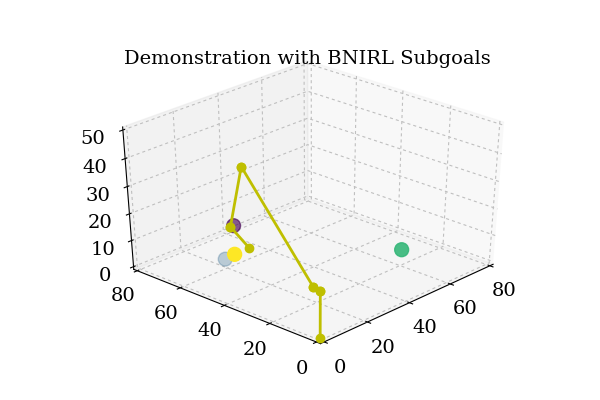

In [170]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# for i in mode_set - set([101, 149]):
#     trajectories.draw_exc(ax, states[i])

def update(i):
    plt.cla()
    plt.title('Demonstration with BNIRL Subgoals', family='serif', fontsize=14)
    ax.scatter(*np.split(subgoals_xyz.T, 3), s=100, c=range(len(mode_set)))
    trajectories.draw_exc(ax, states_condense[i])
    sg_label = int(modes[i])
#     ax.text(60, 60, 40, sg_label, color=colors[mode_color[modes[i]]])

anim = FuncAnimation(fig, update, 
                     frames=range(0, len(states_condense)),
                     interval=200)
# anim.save('BNIRL_subgoal_states.gif', dpi=80, writer='imagemagick')

___

# Animate cluster formation

Show clusters over iteration of Gibbs Sampling

### Popular subgoals

Clusters represent subgoals after i'th iteration, cluster size represents number of states seeking that subgoal after i'th iteration

<IPython.core.display.Javascript object>


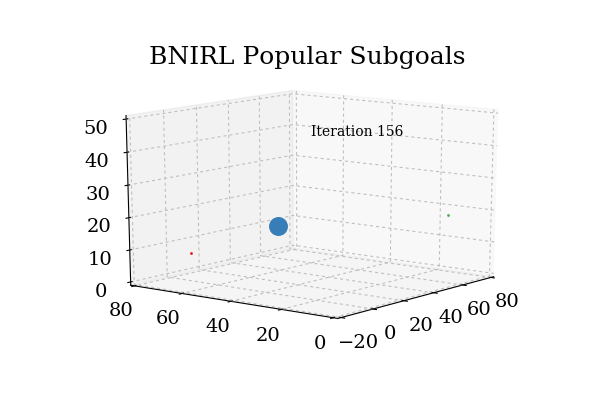

In [245]:
fig = plt.figure()
ax = fig.gca(projection='3d')

def update(i):
    plt.cla()
    modes, _ = stats.mode(partition_dist[brn:brn+1+i])
    mode_set = set([int(mode) for mode in modes[0]])
    
    for mode in mode_set:
        c = np.count_nonzero(modes[0] == mode)
        ax.scatter(*np.split(states_xyz_bias.T[mode], 3), zdir='z', s=c)
    
    ax.text(60, 60, 40, 'Iteration %i' % i)
    
    orient_plot(ax)
    plt.title('BNIRL Popular Subgoals')

anim = FuncAnimation(fig, update, frames=np.arange(0, iters-brn), interval=100)
# anim.save('BNIRL_clustering.gif', dpi=80, writer='imagemagick')

# Observation i Posterior 

Illustrate the posterior distribution for observation $O_i$, along with the state-action pair $(s_i, a_i)$.

<IPython.core.display.Javascript object>


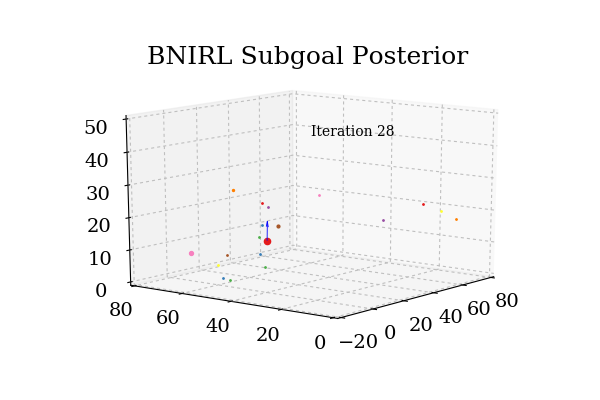

In [265]:
fig = plt.figure()
ax = fig.gca(projection='3d')
obs = 14

args = np.split(states_xyz_bias[:, obs], 3) + np.split(states_project_xyz_bias[:, obs] - states_xyz_bias[:, obs], 3)

def update(i):
    plt.cla()
    samples_i = partition_dist[brn:brn+1+i, obs]
    partition_set = set([int(a) for a in partition_dist[20:21+i, obs]])

    ax.scatter(*np.split(states_xyz_bias[:, obs], 3), zdir='z')
    ax.quiver(*args, length=6, normalize=True, color='b', linewidth=0.6)
    for partition in partition_set:
        c = np.count_nonzero(samples_i == partition)
        ax.scatter(*np.split(states_xyz_bias.T[partition], 3), zdir='z', s=c)

    ax.text(60, 60, 40, 'Iteration %i' % i)
    orient_plot(ax)
    plt.title('BNIRL Subgoal Posterior')

anim = FuncAnimation(fig, update, frames=np.arange(0, iters-brn), interval=100)
# anim.save('BNIRL_clustering2.gif', dpi=80, writer='imagemagick')

___

# DPMIRL

Maske, *et. al.*, Dirichlet process means clustering algorithm using DP-means from [Michael Jordan's paper](http://icml.cc/2012/papers/291.pdf)

In [58]:
reload(learning)

<module 'learning' from 'learning.py'>

In [77]:
from sklearn.preprocessing import normalize

In [79]:
states_condense_normal = normalize(states_condense)
states_condense_normal.shape

(161, 4)

In [88]:
states_xyz.shape

(3, 161)

## Cluster in the Actuator Space

Cluster in the normalized actuator space and show subgoals and convergence.

In [160]:
partition_DPk = [0]*len(states_condense)
iters = 20
mse = np.zeros((iters))
sg_means = []

for i in range(iters):
    partition_DPk = learning.dp_kmeans(states_condense_normal, partition_DPk, lamb=0.4)
    mse[i], sgs = learning.compute_means(partition_DPk, states_condense)
    sg_means.append(sgs)

<IPython.core.display.Javascript object>


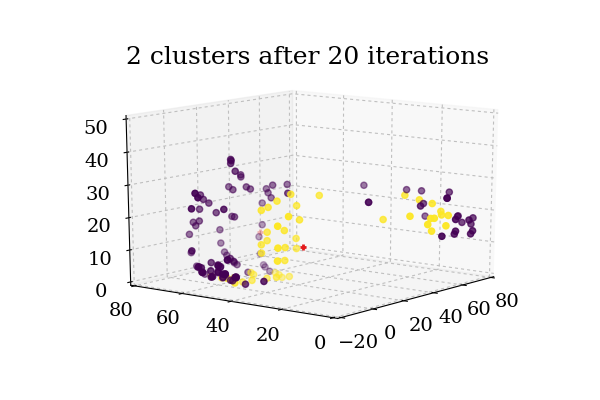

In [161]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('%i clusters after %i iterations' % (len(set(partition_DPk)), iters))

ax.scatter(*np.split(states_xyz_bias, 3), c=partition_DPk, zdir='z')
ax.scatter(*forward_kin_vec(trajectories.exc, sg_means[-1][:, 3], 
           sg_means[-1][:, 0], sg_means[-1][:, 1], sg_means[-1][:, 2], bias=17.1), marker='+')
orient_plot(ax)

# plt.subplot(2, 1, 2)
# plt.plot(mse)
# plt.title('Mean Squared Error at i\'th iteration')

<IPython.core.display.Javascript object>


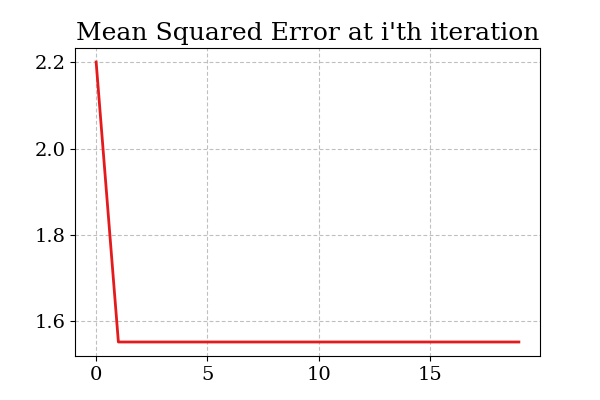

In [162]:
fig = plt.figure()
plt.plot(mse)
plt.title('Mean Squared Error at i\'th iteration')

## Clustering the End-Effector Space

Results in the actuator space are not very good, so we will cluster the end-effector space by tranforming the states first.

In [121]:
states_condense_xyz = np.array(forward_kin_vec(trajectories.exc, states_condense[:, 3],
                                     states_condense[:, 0], states_condense[:, 1],
                                     states_condense[:, 2], bias=17.1))

In [122]:
states_condense_xyz.shape

(3, 161)

In [135]:
partition_DPk = [0]*len(states_condense)
iters = 20
mse = np.zeros((iters))
sg_means = []

for i in range(iters):
    partition_DPk = learning.dp_kmeans(states_condense_xyz.T, partition_DPk, lamb=25.0)
    mse[i], sgs = learning.compute_means(partition_DPk, states_condense)
    sg_means.append(sgs)

<IPython.core.display.Javascript object>


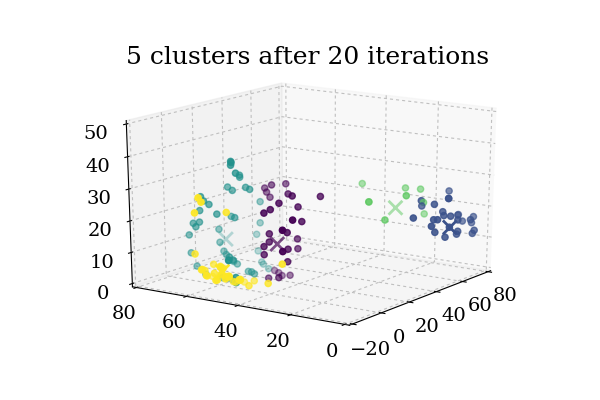

In [143]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('%i clusters after %i iterations' % (len(set(partition_DPk)), iters))

ax.scatter(*np.split(states_xyz_bias, 3), c=partition_DPk, zdir='z')
ax.scatter(*forward_kin_vec(trajectories.exc, sg_means[-1][:, 3], 
           sg_means[-1][:, 0], sg_means[-1][:, 1], sg_means[-1][:, 2], bias=17.1), c=list(set(partition_DPk)), marker='x', s=100)
orient_plot(ax)

# plt.subplot(2, 1, 2)
# plt.plot(mse)
# plt.title('Mean Squared Error at i\'th iteration')

<IPython.core.display.Javascript object>


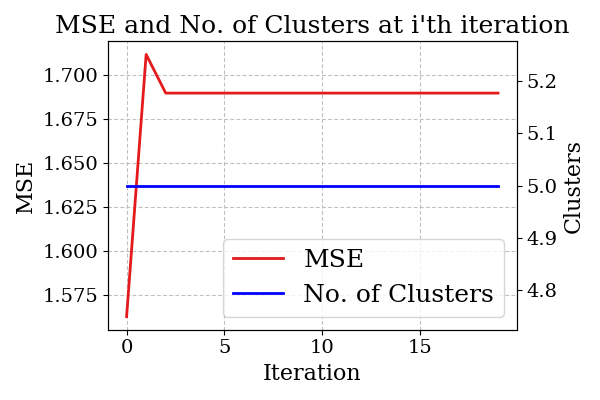

In [155]:
fig = plt.figure()
ax = plt.gca()

ln1 = ax.plot(mse, label='MSE')
ax2 = ax.twinx()
ln2 = ax2.plot([len(sgs) for sgs in sg_means], label='No. of Clusters', c='b')

plt.title('MSE and No. of Clusters at i\'th iteration')

# added these three lines
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

# ax.grid()
ax2.grid()

ax.set_xlabel("Iteration")
ax.set_ylabel('MSE')
ax2.set_ylabel('Clusters')
plt.tight_layout()

Not much information there....